In [1]:
import string
import os
from os.path import join
import glob
import json

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


from naturalcogsci.helpers import get_project_root

PROJECT_ROOT = get_project_root()

mpl.rcParams.update(mpl.rc_params_from_file(join(PROJECT_ROOT, ".matplotlibrc")))

FIGWIDTH = mpl.rcParams["figure.figsize"][0]
CMAP = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
CATEGORYTRIALS = 120
REWARDTRIALS = 60
SMALLER_SIZE = 6



with open(join(PROJECT_ROOT, "data", "model_plot_params.json")) as f:
    plot_params = json.load(f)
plot_params = {k.replace("/", "_"): v for k, v in plot_params.items()}
main_feature_names = list(plot_params.keys())

In [2]:
dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "category_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob),np.log(1 - model_df.prob)
)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["return"] = np.where(np.round(model_df.prob) == model_df.true_category_binary, 1, 0)
chance_level = -model_df.participant.nunique() * CATEGORYTRIALS * np.log(0.5)
model_df = model_df.groupby("features").agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["feature_key"] = model_df["features"]
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
model_df.loc[model_df.nll==1]["nll"] = 0
category_model_df = model_df

In [3]:
dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "reward_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["prob"] = np.where(model_df.prob == 1, 0.99999, model_df.prob)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob), np.log(1 - model_df.prob)
)
chance_level = -model_df.participant.nunique() * REWARDTRIALS * np.log(0.5)
model_df["model_choice"] = np.where(model_df.right_value > model_df.left_value, 1,0)
model_df["best_side"] = np.where(model_df.right_reward > model_df.left_reward, 1, 0)
model_df["return"] = np.where(model_df.model_choice == model_df.best_side,1,0)
model_df = model_df.groupby("features").agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["feature_key"] = model_df["features"]
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
reward_model_df = model_df

In [4]:
merged_df = pd.merge(
    reward_model_df[["features", "color", "nll", "return","feature_key"]],
    category_model_df[["features", "color", "nll", "return","feature_key"]],
    on=["features", "color", "feature_key"],
    suffixes=("_reward", "_category"),
)

merged_df["nll"] = (merged_df["nll_reward"] + merged_df["nll_category"])/2
merged_df["return"] = (merged_df["return_reward"] + merged_df["return_category"])/2
merged_df.drop(["return_reward", "return_category"], axis=1, inplace=True)
merged_df.drop(["nll_reward", "nll_category"], axis=1, inplace=True)
merged_df["model_size"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["size"]
)
merged_df["zero_shot"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["zero-shot"]
)
merged_df["probing"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["probing"]
)

merged_df["training_data"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["data-size"]
)

ax0_df = merged_df[
    merged_df["color"].isin(
        ["supervised", "self-supervised", "multimodal"]
    )
]
ax0_df["model_size"] = pd.to_numeric(ax0_df["model_size"], errors='coerce')

ax0_df.model_size = ax0_df.model_size * 1e6

ax1_df = merged_df[
    merged_df["color"].isin(
        ["supervised", "self-supervised", "multimodal"]
    )
]
ax1_df["training_data"] = pd.to_numeric(ax1_df["training_data"], errors='coerce')


r2_dfs = glob.glob(join(PROJECT_ROOT, "data", "r2", "*.csv"))

dfs = []
for file_path in r2_dfs:
    file_name = os.path.basename(file_path).split(".")[0]
    df = pd.read_csv(file_path)
    df["features"] = file_name
    dfs.append(df)

r2_df = pd.concat(dfs, ignore_index=True)
r2_df = r2_df[r2_df.r2 <= 0.99].reset_index(drop=True)
r2_df = r2_df[r2_df.features.isin(main_feature_names)]

r2_df["color"] = r2_df["features"].apply(lambda x: plot_params[x]["colour"])
r2_df["features"] = r2_df["features"].apply(lambda x: plot_params[x]["name"])

r2_df = pd.merge(r2_df, merged_df, on=["features", "color"], how="outer")

r2_df = r2_df[~r2_df.color.str.startswith("text")].reset_index(drop=True)
r2_df = r2_df[~r2_df.color.str.startswith("task")].reset_index(drop=True)

r2_df = r2_df[~r2_df.isna().any(axis=1)].reset_index(drop=True)

task_cka_df = pd.read_csv(join(PROJECT_ROOT, "data", "cka", "target_task.csv"))
task_cka_df = task_cka_df[task_cka_df.feature.isin(main_feature_names)]
task_cka_df = task_cka_df[task_cka_df.feature != "cornet-rt"].reset_index(drop=True)
task_cka_df = task_cka_df[task_cka_df.feature != "task"].reset_index(drop=True)
task_cka_df["color"] = task_cka_df["feature"].apply(lambda x: plot_params[x]["colour"])

task_cka_df["features"] = task_cka_df["feature"].apply(lambda x: plot_params[x]["name"])
task_cka_df = pd.merge(
    task_cka_df,
    merged_df[["features", "color", "nll"]],
    on=["features", "color"],
    how="outer",
)

task_cka_df["cka"] = np.where(task_cka_df["color"] == "task", 1, task_cka_df["cka"])


task_cka_df = task_cka_df[~task_cka_df.isna().any(axis=1)].reset_index(drop=True)

r2_dfs = glob.glob(join(PROJECT_ROOT, "data", "ID", "*.csv"))

dfs = []
for file_path in r2_dfs:
    file_name = os.path.basename(file_path).split(".")[0]
    df = pd.read_csv(file_path)
    df["features"] = file_name
    dfs.append(df)

id_df = pd.concat(dfs, ignore_index=True)

id_df = id_df[id_df.features.isin(main_feature_names)]

id_df["color"] = id_df["features"].apply(lambda x: plot_params[x]["colour"])
id_df["features"] = id_df["features"].apply(lambda x: plot_params[x]["name"])

id_df = pd.merge(id_df, merged_df, on=["features", "color"], how="outer")
id_df=id_df[id_df.color.isin(["self-supervised","supervised","multimodal"])]

/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72056/4162039254.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ax0_df["model_size"] = pd.to_numeric(ax0_df["model_size"], errors='coerce')
/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72056/4162039254.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ax0_df.model_size = ax0_df.model_size * 1e6
/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72056/4162039254.py:40: SettingWithCopyWarning: 
A value is trying to be se

In [5]:
dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "reward_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["prob"] = np.where(model_df.prob == 1, 0.99999, model_df.prob)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob), np.log(1 - model_df.prob)
)

chance_level = - REWARDTRIALS * np.log(0.5)
model_df["model_choice"] = np.where(model_df.right_value > model_df.left_value, 1,0)
model_df["best_side"] = np.where(model_df.right_reward > model_df.left_reward, 1, 0)
model_df["return"] = np.where(model_df.model_choice == model_df.best_side,1,0)
model_df = model_df.groupby(["features","participant"]).agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["feature_key"] = model_df["features"]
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
reward_model_df = model_df


dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "category_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob),np.log(1 - model_df.prob)
)

model_df["right_value"] = np.where(model_df.right_value == 1, 0.99999, model_df.right_value)
model_df["right_value"] = np.where(model_df.right_value == 0, 0.000001, model_df.right_value)
#model_df["nll"] = - np.log(model_df.right_value)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["return"] = np.where(np.round(model_df.prob) == model_df.true_category_binary, 1, 0)
#model_df["return"] = np.where(np.round(model_df.right_value) == model_df.true_category_binary, 1, 0)
chance_level = -CATEGORYTRIALS * np.log(0.5)
model_df = model_df.groupby(["features","participant"]).agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["feature_key"] = model_df["features"]
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
category_model_df = model_df

In [6]:
category_model_df.loc[:,"task"] = "category"
category_model_df = category_model_df[["features","participant","nll","task", "return"]]

reward_model_df.loc[:,"task"] = "category"
reward_model_df = reward_model_df[["features","participant","nll","task", "return"]]

slip_df = pd.concat([category_model_df,reward_model_df])

In [7]:
slip_df = slip_df[slip_df['features'].str.contains('SLIP')]
slip_cmap = [CMAP[3],CMAP[2],CMAP[3]]
def assign_size(feature):
    if "Base" in feature:
        return "Base"
    elif "Large" in feature:
        return "Large"
    else:
        return "Small"

def assign_loss(feature):
    if "CLIP" in feature:
        return "CLIP"
    elif "SimCLR" in feature:
        return "SimCLR"
    else:
        return "CLIP + SimCLR"
slip_df["Size"] = slip_df.features.apply(assign_size)
slip_df["Model"] = slip_df.features.apply(assign_loss)
slip_df['r2'] = slip_df['features'].map(r2_df.set_index('features')['r2'])
slip_df['cka'] = slip_df['features'].map(task_cka_df.set_index('features')['cka'])
slip_df['id'] = slip_df['features'].map(id_df.set_index('features')['local ID'])

/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72056/2337606689.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(data=slip_df,x="Size",y="nll",hue="Model",ax=axs[0],order=["Small", "Base", "Large"],palette=slip_cmap,hue_order=["CLIP","SimCLR","CLIP + SimCLR"],errwidth=1)
/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72056/2337606689.py:17: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(data=slip_df,x="Size",y="return",hue="Model",ax=axs[1],order=["Small", "Base", "Large"],palette=slip_cmap,hue_order=["CLIP","SimCLR","CLIP + SimCLR"],errwidth=1)
/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72056/2337606689.py:30: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barp

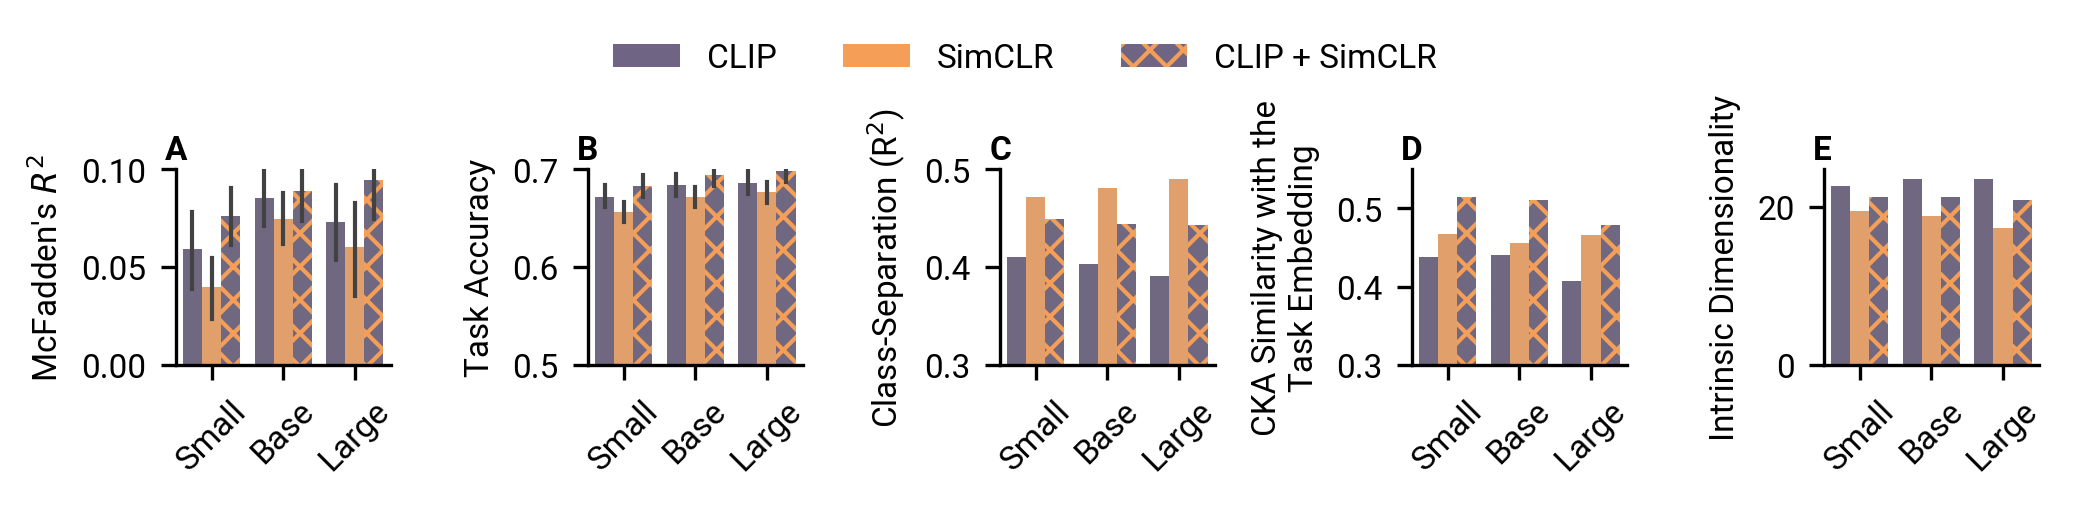

In [8]:
plt.rcParams.update({'hatch.color': CMAP[2]})
fig, axs = plt.subplots(1,5, figsize=(FIGWIDTH, FIGWIDTH/5))


sns.barplot(data=slip_df,x="Size",y="nll",hue="Model",ax=axs[0],order=["Small", "Base", "Large"],palette=slip_cmap,hue_order=["CLIP","SimCLR","CLIP + SimCLR"],errwidth=1)
axs[0].set_ylabel(r"McFadden's $R^2$")
axs[0].set_ylim(0,.1)
axs[0].set_xlabel("")
num_hue_levels = slip_df['Model'].nunique()
hatches = ["xxx" if x=="SimCLR" else "" for x in slip_df.Model.values] * num_hue_levels
hatches = ["","",""] * 3
for i in ([-1,-2,-3]):
    hatches[i] = "xxx"
for hatch, patch in zip(hatches, axs[0].patches):
     patch.set_hatch(hatch)

sns.barplot(data=slip_df,x="Size",y="return",hue="Model",ax=axs[1],order=["Small", "Base", "Large"],palette=slip_cmap,hue_order=["CLIP","SimCLR","CLIP + SimCLR"],errwidth=1)
axs[1].set_ylabel("Task Accuracy")
axs[1].set_xlabel("")
axs[1].set_ylim(.5,.7)
axs[1].set_yticks([.5,.6,.7])
num_hue_levels = slip_df['Model'].nunique()
hatches = ["","",""] * 3
for i in ([-1,-2,-3]):
    hatches[i] = "xxx"
for hatch, patch in zip(hatches, axs[1].patches):
     patch.set_hatch(hatch)


sns.barplot(data=slip_df,x="Size",y="r2",hue="Model",ax=axs[2],order=["Small", "Base", "Large"],palette=slip_cmap,hue_order=["CLIP","SimCLR","CLIP + SimCLR"],errwidth=1)
axs[2].set_xlabel("")
axs[2].set_ylabel("Class-Separation (R$^2$)")
axs[2].set_yticks([.3,.4,.5])
axs[2].set_ylim(.3,.5)
num_hue_levels = slip_df['Model'].nunique()
hatches = ["","",""] * 3
for i in ([-1,-2,-3]):
    hatches[i] = "xxx"
for hatch, patch in zip(hatches, axs[2].patches):
     patch.set_hatch(hatch)

sns.barplot(data=slip_df,x="Size",y="cka",hue="Model",ax=axs[3],order=["Small", "Base", "Large"],palette=slip_cmap,hue_order=["CLIP","SimCLR","CLIP + SimCLR"],errwidth=1)
axs[3].set_xlabel("")
axs[3].set_ylabel("CKA Similarity with the\nTask Embedding")
axs[3].set_ylim(.4,.55)
axs[3].set_yticks([.3,.4,.5])
num_hue_levels = slip_df['Model'].nunique()
hatches = ["","",""] * 3
for i in ([-1,-2,-3]):
    hatches[i] = "xxx"
for hatch, patch in zip(hatches, axs[3].patches):
     patch.set_hatch(hatch)

sns.barplot(data=slip_df,x="Size",y="id",hue="Model",ax=axs[4],order=["Small", "Base", "Large"],palette=slip_cmap,hue_order=["CLIP","SimCLR","CLIP + SimCLR"],errwidth=1)
axs[4].set_xlabel("")
axs[4].set_ylabel("Intrinsic Dimensionality")
num_hue_levels = slip_df['Model'].nunique()
hatches = ["","",""] * 3
for i in ([-1,-2,-3]):
    hatches[i] = "xxx"
for hatch, patch in zip(hatches, axs[4].patches):
     patch.set_hatch(hatch)




for ax in axs:  

    ax.legend_.remove()



custom_legend_lines = [
    mpatches.Patch(
        facecolor=x,
        edgecolor=None,
        lw=2,
    )
    for x in [CMAP[3],CMAP[2]]
]


human_aligned_bar = mpatches.Patch(facecolor=CMAP[3], edgecolor=None, hatch='xxx', label='Human Aligned')



# Append the new bar and label to the existing lists
custom_legend_lines.append(human_aligned_bar)
hue_order = [
    "CLIP",
    "SimCLR",
    "CLIP + SimCLR"
]
fig.legend(
    custom_legend_lines,
    hue_order,
    loc="center",
    bbox_to_anchor=(0.5, 1.08),
    ncol=6,
    frameon=False,
)


axs[0].text(-.05, 1.05, string.ascii_uppercase[0], transform=axs[0].transAxes, weight="bold")
axs[1].text(-.05, 1.05, string.ascii_uppercase[1], transform=axs[1].transAxes, weight="bold")
axs[2].text(-.05, 1.05, string.ascii_uppercase[2], transform=axs[2].transAxes, weight="bold")
axs[3].text(-.05, 1.05, string.ascii_uppercase[3], transform=axs[3].transAxes, weight="bold")
axs[4].text(-.05, 1.05, string.ascii_uppercase[4], transform=axs[4].transAxes, weight="bold")
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()


fig.savefig(join(PROJECT_ROOT, "figures","neurips_slip_investigations.pdf"), bbox_inches='tight')